In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/disease-symptom-description-dataset/symptom_Description.csv
/kaggle/input/disease-symptom-description-dataset/Symptom-severity.csv
/kaggle/input/disease-symptom-description-dataset/symptom_precaution.csv
/kaggle/input/disease-symptom-description-dataset/dataset.csv
/kaggle/input/diseases-and-symptoms-dataset/Final_Augmented_dataset_Diseases_and_Symptoms.csv


In [16]:

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegressionCV
from sklearn.calibration import CalibratedClassifierCV
from scipy.spatial.distance import cosine
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
from gensim.models import Word2Vec

In [17]:
df=pd.read_csv('/kaggle/input/disease-symptom-description-dataset/dataset.csv')

In [18]:
df.head()

,Disease,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5,Symptom_6,Symptom_7,Symptom_8,Symptom_9,Symptom_10,Symptom_11,Symptom_12,Symptom_13,Symptom_14,Symptom_15,Symptom_16,Symptom_17
0,Fungal infection,itching,skin_rash,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Fungal infection,skin_rash,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Fungal infection,itching,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Fungal infection,itching,skin_rash,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Fungal infection,itching,skin_rash,nodal_skin_eruptions,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
df.fillna('none', inplace=True)

In [20]:
le = LabelEncoder()
df['Disease_Encoded'] = le.fit_transform(df['Disease'])

In [21]:
symptoms = df.loc[:, 'Symptom_1':'Symptom_17'].values.flatten()
unique_symptoms = pd.Series(symptoms).value_counts()

In [22]:
all_symptoms = df.loc[:, 'Symptom_1':'Symptom_17'].values.flatten()
symptom_texts = df.apply(lambda row: ' '.join(row['Symptom_'+str(i)] for i in range(1, 18) if row['Symptom_'+str(i)] != 'none'), axis=1)
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(symptom_texts)


In [23]:
co_occurrence = pd.DataFrame(0, index=unique_symptoms.index, columns=unique_symptoms.index)

for _, row in df.iterrows():
    symptoms_present = row[['Symptom_' + str(i) for i in range(1, 18)]].values
    symptoms_present = [s for s in symptoms_present if s != 'none']
    for s1 in symptoms_present:
        for s2 in symptoms_present:
            co_occurrence.loc[s1, s2] += 1

In [24]:
G = nx.from_pandas_adjacency(co_occurrence)
communities = nx.community.greedy_modularity_communities(G)

In [28]:
symptom_lists = df.loc[:, 'Symptom_1':'Symptom_17'].apply(lambda x: [s for s in x if s != 'none'], axis=1).tolist()
word2vec_model = Word2Vec(sentences=symptom_lists, vector_size=50, window=5, min_count=1, workers=4)

symptom_vectors = []
symptom_names = []
for symptom in unique_symptoms.index:
    if symptom != 'none':
        symptom_names.append(symptom)
        symptom_vectors.append(word2vec_model.wv[symptom])

symptom_vectors = np.array(symptom_vectors)


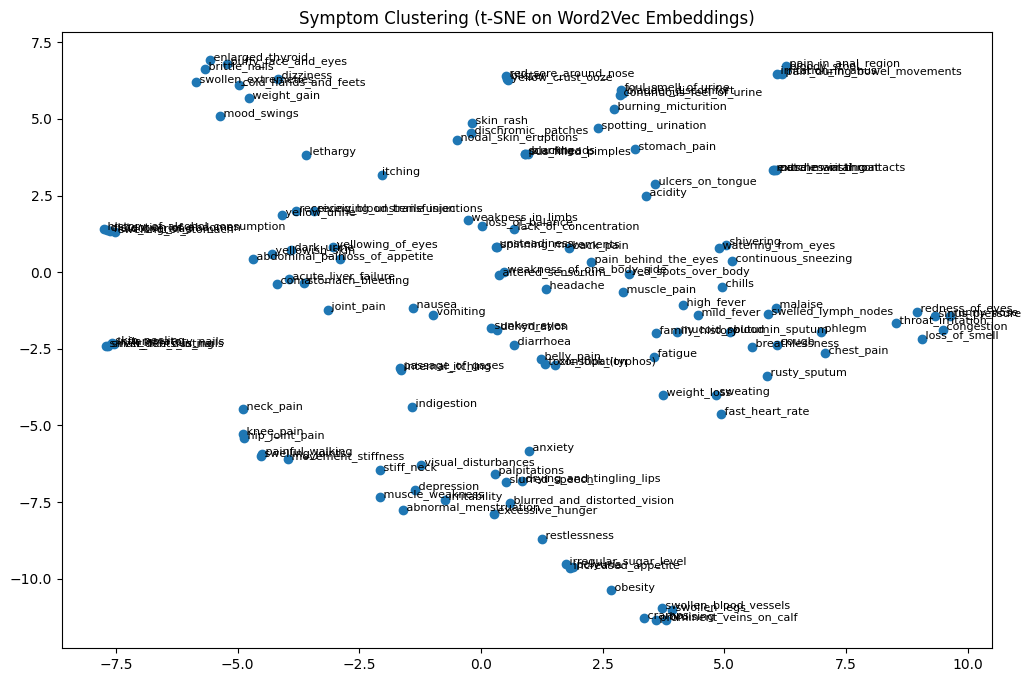

In [29]:
embedding = TSNE(n_components=2, random_state=42).fit_transform(symptom_vectors)
plt.figure(figsize=(12, 8))
plt.scatter(embedding[:, 0], embedding[:, 1])
for i, sym in enumerate(symptom_names):
    plt.annotate(sym, (embedding[i, 0], embedding[i, 1]), fontsize=8)
plt.title("Symptom Clustering (t-SNE on Word2Vec Embeddings)")
plt.show()

In [30]:
symptom_freq = unique_symptoms.to_dict()
def bayesian_weight(symptom, prior=1, base=10):
    freq = symptom_freq.get(symptom, 1)
    return (freq + prior) / (freq + base)


In [31]:
# Convert symptoms to binary presence/absence matrix
binary_matrix = pd.DataFrame(0, index=df.index, columns=unique_symptoms.index)

for index, row in df.iterrows():
    symptoms_present = row[['Symptom_' + str(i) for i in range(1, 18)]].values
    for s in symptoms_present:
        if s != 'none':
            binary_matrix.loc[index, s] = 1

In [36]:
import numpy as np
import pandas as pd

# Step 1: Remove constant columns (with zero variance)
constant_cols = binary_matrix.columns[binary_matrix.nunique() <= 1]
binary_matrix_clean = binary_matrix.drop(columns=constant_cols)

# Step 2: Compute correlation
corr_matrix = binary_matrix_clean.corr().abs()

# Step 3: Handle potential NaNs (replace with 0)
corr_matrix = corr_matrix.fillna(0)

# Step 4: Prune highly correlated features
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# Step 5: Drop those columns
binary_matrix_pruned = binary_matrix_clean.drop(columns=to_drop)

print(f"Dropped {len(to_drop)} highly correlated features.")

Dropped 0 highly correlated features.


/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


In [35]:
corr_matrix = binary_matrix.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
binary_matrix.drop(columns=to_drop, inplace=True)


/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


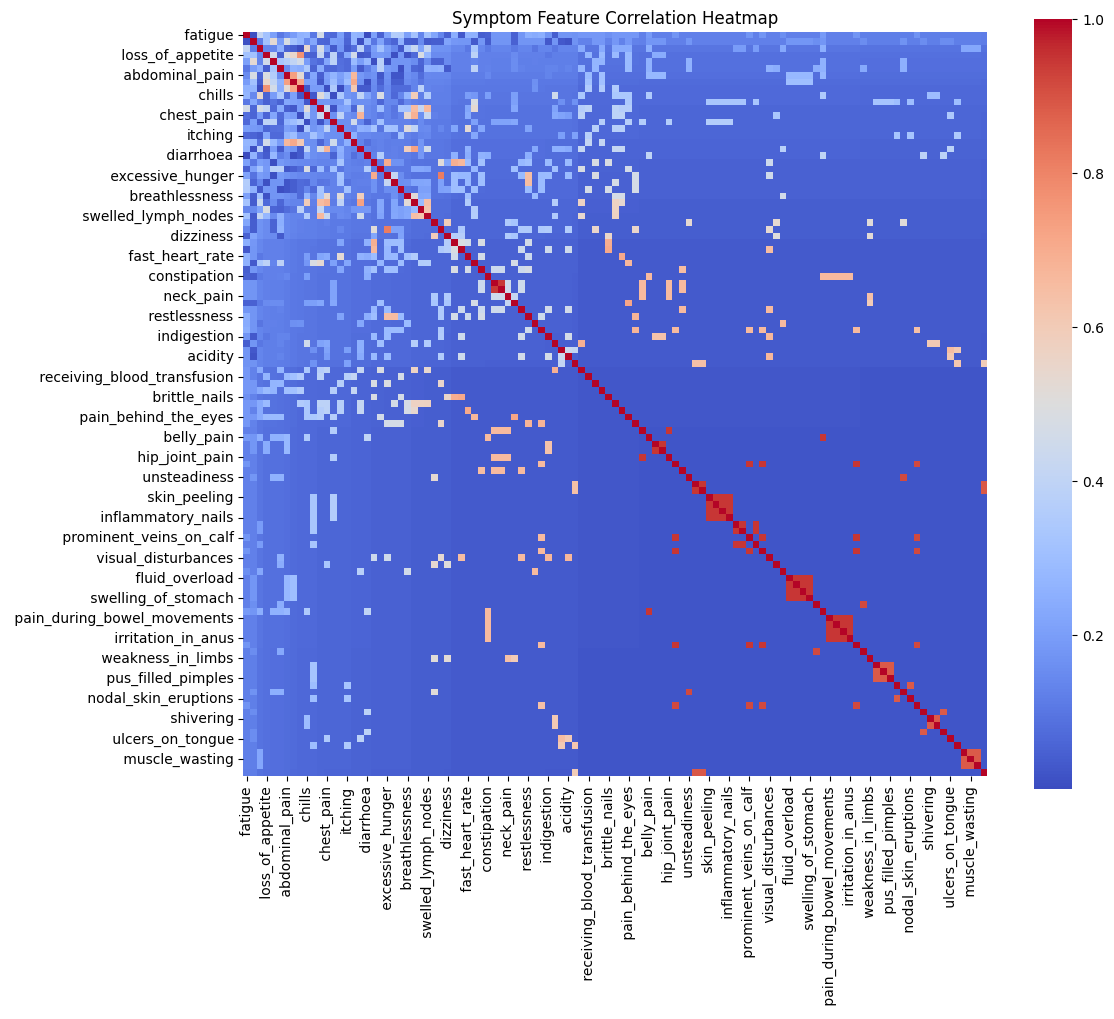

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, cmap='coolwarm', vmax=1.0, square=True)
plt.title("Symptom Feature Correlation Heatmap")
plt.show()


In [38]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(binary_matrix, df['Disease_Encoded'], test_size=0.2, random_state=42)

rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)

calibrated_model = CalibratedClassifierCV(base_estimator=rf_model, method='isotonic', cv=3)
calibrated_model.fit(X_train, y_train)

# Save calibrated model
import joblib
joblib.dump(calibrated_model, 'calibrated_disease_model.pkl')

/usr/local/lib/python3.10/dist-packages/sklearn/calibration.py:321: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


['calibrated_disease_model.pkl']

In [53]:
def find_symptom_boosting_confidence(calibrated_model, user_vector, current_confidence, asked_symptoms, symptom_columns):
    candidate_symptoms = list(set(symptom_columns) - asked_symptoms)
    best_symptom = None
    max_boost = 0
    
    for symptom in candidate_symptoms:
        temp_vector = user_vector.copy()
        temp_vector[symptom] = 1  # Simulate a 'yes' response
        temp_proba = calibrated_model.predict_proba([temp_vector])[0]
        new_confidence = np.max(temp_proba)
        boost = new_confidence - current_confidence
        if boost > max_boost:
            max_boost = boost
            best_symptom = symptom
    
    return best_symptom, max_boost

def dynamic_questioning_confidence_boost(calibrated_model, symptom_columns, initial_symptoms):
    user_input_vector = pd.Series(0, index=symptom_columns)
    for s in initial_symptoms:
        if s in user_input_vector.index:
            user_input_vector[s] = 1
    
    asked_symptoms = set(initial_symptoms)
    question_count = 0
    
    while question_count < MAX_QUESTIONS:
        pred_proba = calibrated_model.predict_proba([user_input_vector])[0]
        confidence = np.max(pred_proba)
        
        if confidence >= CONFIDENCE_THRESHOLD:
            break
        
        # Find symptom that boosts confidence the most
        next_symptom, boost = find_symptom_boosting_confidence(calibrated_model, user_input_vector, confidence, asked_symptoms, symptom_columns)
        
        if next_symptom is None:
            break  # No symptom improves confidence
        
        answer = input(f"Do you have {next_symptom.replace('_',' ')}? (yes/no): ").strip().lower()
        user_input_vector[next_symptom] = 1 if answer == 'yes' else 0
        asked_symptoms.add(next_symptom)
        question_count += 1
    
    final_proba = calibrated_model.predict_proba([user_input_vector])[0]
    final_confidence = np.max(final_proba)
    final_disease = disease_labels[np.argmax(final_proba)]
    
    print("\n✅ Diagnosis Complete!")
    print(f"Predicted Disease: {final_disease}")
    print(f"Confidence: {round(final_confidence * 100, 2)}%")
    print(f"Total questions asked: {len(asked_symptoms) - len(initial_symptoms)}")
    print(f"Remaining symptoms not asked: {len(symptom_columns) - len(asked_symptoms)}")

# Example Usage
initial_symptoms = ['itching', 'skin_rash']
dynamic_questioning_confidence_boost(calibrated_model, symptom_columns, initial_symptoms)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X

Do you have  dischromic  patches? (yes/no):  no


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X

Do you have  nodal skin eruptions? (yes/no):  yes



✅ Diagnosis Complete!
Predicted Disease: Fungal infection
Confidence: 97.61%
Total questions asked: 2
Remaining symptoms not asked: 108


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X

In [54]:
df.head()

,Disease,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5,Symptom_6,Symptom_7,Symptom_8,Symptom_9,Symptom_10,Symptom_11,Symptom_12,Symptom_13,Symptom_14,Symptom_15,Symptom_16,Symptom_17,Disease_Encoded
0,Fungal infection,itching,skin_rash,nodal_skin_eruptions,dischromic _patches,none,none,none,none,none,none,none,none,none,none,none,none,none,15
1,Fungal infection,skin_rash,nodal_skin_eruptions,dischromic _patches,none,none,none,none,none,none,none,none,none,none,none,none,none,none,15
2,Fungal infection,itching,nodal_skin_eruptions,dischromic _patches,none,none,none,none,none,none,none,none,none,none,none,none,none,none,15
3,Fungal infection,itching,skin_rash,dischromic _patches,none,none,none,none,none,none,none,none,none,none,none,none,none,none,15
4,Fungal infection,itching,skin_rash,nodal_skin_eruptions,none,none,none,none,none,none,none,none,none,none,none,none,none,none,15
